# Analysis with Coffea

<h2>Authors</h2>
<b>Notebook by:</b> Mat Adamec (<i>UNL</i>)
<br/>
<br/>
<b>coffea:</b>
<br/>
<a href="https://doi.org/10.5281/zenodo.6335374"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.6335374.svg" alt="DOI"></a>
<br/>
    <ul>
        <li>Lindsey Gray, Matteo Cremonesi, Bo Jayatilaka, Oliver Gutsche, Nick Smith, Allison Hall, Kevin Pedro, Maria Acosta <i>(FNAL)</i>; Andrew Melo <i>(Vanderbilt)</i>; Stefano Belforte <i>(INFN)</i>; and others</li>
        <li>In collaboration with IRIS-HEP members: Jim Pivarski <i>(Princeton)</i>, Ben Galewsky <i>(NCSA)</i>, Mark Neubauer <i>(UIUC)</i></li>
        <br/>
    </ul>
<b><a href="https://github.com/CoffeaTeam/coffea-casa">coffea-casa</a>:</b>
    <ul>
        <li>Ken Bloom, Oksana Shadura <i>(UNL)</i>; Garhan Attebury, Carl Lundstedt, Derek Weitzel <i>(UNL-HCC)</i>; Mátyás Selmeci <i>(UWM)</i>; Brian Bockelman <i>(Morgridge Institute)</i></li>
    </ul>

## What is Coffea?

Coffea stands for *Columnar Object Framework For Effective Analysis.* It contains a variety of tools which help physicists perform their analyses in a columnar fashion. By "a columnar fashion," we mean that data is contained in numpy-like arrays upon which we can perform operations without calling an explicit event loop. Coffea is built on Awkward arrays and any Awkward operation can be done in a Coffea analysis. Beyond this, Coffea's analysis features can be broken into roughly four categories:

* **NanoEvents** turns data into an Awkward array wrapped with a schema. The schema serves a variety of purposes, from enabling us to interpret data as physics objects (e.g., LorentzVectors) to handling the nesting of our fields and creating relevant physical cross-references. In short: NanoEvents makes our data act nicely in the context of a physics analysis. A schema can be made for any ntuple file.

* **Hists** permit the plotting of ROOT-like histograms with Coffea.

* **Processors** are Coffea's way of encapsulating an analysis in a way that is deployment-neutral. Once you have a Coffea analysis, you can throw it into a processor and use any of a variety of executors (e.g. Dask, Parsl, Spark) to chunk it up and run it across distributed workers. This makes scale-out simple and dynamic on the user's end.

* **Lookup tools** are available in Coffea for any corrections that need to be made to physics data. These tools read a variety of correction file formats and turn them into lookup tables.

We will go through the first three points within this tutorial. As corrections tend to be experiment-specific, they are outside our scope, but the coffea docs offer some [examples](https://coffeateam.github.io/coffea/notebooks/applying_corrections.html) from a CMS perspective.

## A Motivating Comparison

Placeholder. Showcase coffea vs. event loop to motivate why we'd want to use it.
* Find a suitable analysis for this.
* Maybe show the analysis we'll build through the tutorial, just to also show "where we'll end up?"
* If we do make a comparison here, then imports/NanoAODSchema warning messages will be here, so they remain here for now.

In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist
import awkward as ak
import numpy as np

# NanoEvents will try to build crossrefs that aren't in our file! Silence this as it's irrelevant for our purposes.
NanoAODSchema.warn_missing_crossrefs = False

## **Preliminary**: Data with Awkward

As mentioned in the overview, NanoEvents bundles data with physical meaning. We input some nTuple file and we get an awkward array with the desirable physics methods.

To use NanoEvents, we of course need data. (Insert information about the file we'll be using. Currently, we're using a placeholder.)

The simplest way to access our data is to use NanoEventsFactory. Note that I will only take the first 100000 events in our file - this ensures we don't end up waiting for blocks to process. You can remove this constraint if you desire.

In [ ]:
events = NanoEventsFactory.from_root("root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root", entry_stop=100000).events()

NameError: name 'NanoEventsFactory' is not defined

What does our data look like? Well, it's an awkward array! If you missed the talk about awkward, you can imagine an awkward array as a numpy array that can handle jagged (non-rectangular) data. We won't dive too deep into its details - but we will at least explore the structure of our NanoEvents array. Let's look at <code>events</code>:

In [3]:
events

<NanoEventsArray [<event 194711:299:263142897>, ... ] type='100000 * event'>

What does this mean? Well, we have an array of size 100000 which is populated with <code>event</code> entries. Each <code>event</code> contains a variable amount of the data we are interested in. We can see the data that is contains by exploring its <code>fields</code>.

In [4]:
events.fields

['PV',
 'Electron',
 'run',
 'MET',
 'Muon',
 'Photon',
 'Jet',
 'event',
 'Tau',
 'HLT',
 'luminosityBlock']

As this is a muon dataset, let's look at <code>Muon</code>.

In [5]:
events.Muon

<MuonArray [[Muon], [Muon], ... [Muon, Muon]] type='100000 * var * muon'>

Looking at <code>events.Muon</code> we begin to see the jagged structure of our events array. Each subarray in <code>MuonArray</code> represents one event (note that the size of <code>MuonArray</code> is still 100000). Then, each event can have one Muon, n Muons, or none in its subarray. Of course, this is what we expect to be the case physically, but we now have a data structure that can represent it. That's the beauty of awkward!

To drive the point home, let's count up the number of muons across all of our events.

In [6]:
ak.sum(ak.num(events.Muon, axis=-1))

136481

A quick note about axes in Awkward: 0 is always the shallowest, while -1 is the deepest. In other words, <code>axis=0</code> would tell us the number of subarrays, while <code>axis=-1</code> sums up the number of muons in each subarray. In this case, <code>axis=1</code> works just as well; <code>axis=2</code> is meaningless since our subarrays have no further subarrays within them.

Now we have some idea about the structure of our data. How do we actually get information about a <code>Muon</code>, though? Well, a <code>Muon</code> has its own fields:

In [7]:
events.Muon.fields

['charge',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eta',
 'genPartIdx',
 'jetIdx',
 'jetIdxG',
 'mass',
 'pfRelIso03_all',
 'pfRelIso04_all',
 'phi',
 'pt',
 'softId',
 'tightId']

And these fields can be accessed in the same way that we accessed Muons! The p<sub>T</sub>, for example:

In [8]:
events.Muon.pt

<Array [[12.8], [24.8], ... [14.8, 4.89]] type='100000 * var * float32[parameter...'>

Note, as a sanity check, that the shape of this array is the same as that of the Muon array above. Indeed:

In [9]:
ak.sum(ak.num(events.Muon.pt))

136481

Now that we know how to access data, we can manipulate it as we desire in the standard awkward way. Most cuts in columnar analysis are achieved through masking. Shortly, a mask is a Boolean array which is generated by performing a conditional on a data array. For example, if we want only muons with a p<sub>T</sub> > 10, our mask would be:

In [10]:
events.Muon.pt > 10

<Array [[True], [True], ... [True, False]] type='100000 * var * bool'>

Then, we can apply the mask to our data. This will pick out only the elements of our data which correspond to a <code>True</code>. The data and the mask thus must have the same shape up to the depth of the selection. Since we're making a selection on muons, the mask must have the exact same shape as the data. If we made a selection on events, the mask should be flat with size 100000. The shape of the output array will differ from the data and mask arrays since we are downselecting data.

In [11]:
events.Muon.pt[events.Muon.pt > 10]

<Array [[12.8], [24.8], ... [38.7], [14.8]] type='100000 * var * float32[paramet...'>

Note that we still have 100000 subarrays, as we still have 100000 events, as we only did a selection on muons. If an event had a muon which didn't meet the cut, then that event just has an empty subarray now.

Compare the output array to our original data array. The last Muon, with a pT of 4.89, is no longer present in the array. We'd expect to have fewer muons overall. Let's take another count!

In [12]:
ak.sum(ak.num(events.Muon.pt[events.Muon.pt > 10]))

109624

Conversely, the set of muons whose pT is less than 10 can also be examined.

In [13]:
events.Muon.pt[events.Muon.pt < 10]

<Array [[], [], [6.99, 3.35, ... [], [4.89]] type='100000 * var * float32[parame...'>

Here, we see the last Muon *is* present, as we'd expect. Doing some rough math, we'd expect this array to be 136481 - 109624 = 26857 elements in length.

In [14]:
ak.sum(ak.num(events.Muon.pt[events.Muon.pt < 10]))

26857

## **NanoEvents**

One might now rightfully ask: how is NanoEvents different from awkward?

Fundamentally, NanoEvents builds upon awkward by imposing a schema onto the data. This schema ensures that fields are properly nested, that appropriate physics methods are generated for different objects, and that certain fields are cross-referenced where such references might be desired. For NanoAOD files, the standard schema is [NanoAODSchema](https://coffeateam.github.io/coffea/api/coffea.nanoevents.NanoAODSchema.html), but users can create their own schema for whatever nTuple file-type they may be working with, and they can impose any behavior which is desirable for their particular data. The coffea team welcomes new schema models from the community.

Let's visualize what this all means. First, nesting. The exact methodology by which NanoAODSchema generates its arrays is specified in the documentation, but let's spend a second exploring their application to our file. The branches of our events are:

In [15]:
import uproot
branches = uproot.open("root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root", nax_num_elements=100000)['Events']
branches.keys()

['run',
 'luminosityBlock',
 'event',
 'HLT_IsoMu24_eta2p1',
 'HLT_IsoMu24',
 'HLT_IsoMu17_eta2p1_LooseIsoPFTau20',
 'PV_npvs',
 'PV_x',
 'PV_y',
 'PV_z',
 'nMuon',
 'Muon_pt',
 'Muon_eta',
 'Muon_phi',
 'Muon_mass',
 'Muon_charge',
 'Muon_pfRelIso03_all',
 'Muon_pfRelIso04_all',
 'Muon_tightId',
 'Muon_softId',
 'Muon_dxy',
 'Muon_dxyErr',
 'Muon_dz',
 'Muon_dzErr',
 'Muon_jetIdx',
 'Muon_genPartIdx',
 'nElectron',
 'Electron_pt',
 'Electron_eta',
 'Electron_phi',
 'Electron_mass',
 'Electron_charge',
 'Electron_pfRelIso03_all',
 'Electron_dxy',
 'Electron_dxyErr',
 'Electron_dz',
 'Electron_dzErr',
 'Electron_cutBasedId',
 'Electron_pfId',
 'Electron_jetIdx',
 'Electron_genPartIdx',
 'nTau',
 'Tau_pt',
 'Tau_eta',
 'Tau_phi',
 'Tau_mass',
 'Tau_charge',
 'Tau_decayMode',
 'Tau_relIso_all',
 'Tau_jetIdx',
 'Tau_genPartIdx',
 'Tau_idDecayMode',
 'Tau_idIsoRaw',
 'Tau_idIsoVLoose',
 'Tau_idIsoLoose',
 'Tau_idIsoMedium',
 'Tau_idIsoTight',
 'Tau_idAntiEleLoose',
 'Tau_idAntiEleMedium',
 

That's a mouthful. Let's narrow our focus to the Muon branches:

In [16]:
for branch in branches.keys():
    if 'Muon' in branch:
        print(branch)

nMuon
Muon_pt
Muon_eta
Muon_phi
Muon_mass
Muon_charge
Muon_pfRelIso03_all
Muon_pfRelIso04_all
Muon_tightId
Muon_softId
Muon_dxy
Muon_dxyErr
Muon_dz
Muon_dzErr
Muon_jetIdx
Muon_genPartIdx


The NanoAODSchema handles several naming schemes. The appropriate rule for the Muon branches, however, is:

> From those arrays, NanoAOD collections are formed as collections of branches grouped by name, where:
> <br>... 
> <br> <ul><li>one branch exists named n{name} and many branches start with name_*, interpreted as a jagged table.</li></ul>



In other words, the behavior we'd expect for our NanoEvents Muon array is that each Muon branch is grouped by Muon, and each Muon branch has nMuon entries for each event. This is the exact behavior we saw in the preliminary section above. To reiterate:

In [17]:
events.fields

['PV',
 'Electron',
 'run',
 'MET',
 'Muon',
 'Photon',
 'Jet',
 'event',
 'Tau',
 'HLT',
 'luminosityBlock']

In [18]:
events.Muon.fields

['charge',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eta',
 'genPartIdx',
 'jetIdx',
 'jetIdxG',
 'mass',
 'pfRelIso03_all',
 'pfRelIso04_all',
 'phi',
 'pt',
 'softId',
 'tightId']

In [19]:
ak.num(events.Muon.pt, axis=1), ak.num(events.Muon.dxy, axis=1), ak.num(events.Muon.charge, axis=1)

(<Array [1, 1, 6, 1, 1, 1, ... 1, 1, 1, 2, 1, 2] type='100000 * int64'>,
 <Array [1, 1, 6, 1, 1, 1, ... 1, 1, 1, 2, 1, 2] type='100000 * int64'>,
 <Array [1, 1, 6, 1, 1, 1, ... 1, 1, 1, 2, 1, 2] type='100000 * int64'>)

Which corresponds to the counts in the nMuon branch of our TTree:

In [20]:
branches['nMuon'].array()

<Array [1, 1, 6, 1, 1, 1, ... 1, 2, 1, 1, 1, 1] type='53446198 * uint32'>

To reiterate, this is merely one nesting structure. Schemas can be created for any nTuple file type, and their behavior for handling nesting can be defined by the user.

Now, we turn our attention to another feature of NanoEvents schemas: physics methods! Note, from our Muon fields, we have the ingredients for a LorentzVector: pt eta, phi and mass. With pure awkward, we could zip together these fields manually into an array with PtEtaPhiMLorentzVector behavior.

In [21]:
LorVec = ak.zip({'pt': events.Muon.pt,
            'eta': events.Muon.eta, 
            'phi': events.Muon.phi, 
            'mass': events.Muon.mass}, with_name="PtEtaPhiMLorentzVector")

(LorVec[0] + LorVec[1]).pt

<Array [12.6] type='1 * float32'>

But we don't have to, because our NanoEvents schema treats the <code>Muon</code> objects in <code>MuonArray</code> as LorentzVectors! Physics behavior can be automatically built in to NanoEvents arrays, whereas it has to be imposed explicitly in awkward.

In [22]:
(events.Muon[0] + events.Muon[1]).pt

<Array [12.6] type='1 * float32'>

One other implication of this feature is that, in addition to the fields explicitly mentioned under the MuonArray, we can also access other LorentzVector formulations with NanoEvents:

In [23]:
events.Muon.x, events.Muon.y, events.Muon.z, events.Muon.energy

(<Array [[10.2], [-22.5], ... [-3.73, -3.47]] type='100000 * var * float32'>,
 <Array [[7.71], [-10.3], ... [14.4, 3.44]] type='100000 * var * float32'>,
 <Array [[-8.49], [-19.3], ... [-23.8, 20]] type='100000 * var * float32'>,
 <Array [[15.3], [31.4], ... [28.1, 20.6]] type='100000 * var * float32'>)

And we have the standard LorentzVector methods defined, such as delta_r for computing the distance between two four-vectors:

In [24]:
events.Muon[0].delta_r(events.Muon[1])

<Array [2.92] type='1 * float32'>

** If possible, we should add examples of cross-references here, but I don't think the open data file we're currently using has any, and the file we end up working with could be anything.

## **Hists**

We have data, we can work with our data, and we undoubtedly want to move on from looking at code to looking at pretty colors.

Let's do a simple example and plot the dilepton mass of opposite-charge, same-flavor lepton pairs. This should give us a peak at ~91.12, the mass of the Z boson, as many such dilepton pairs result from Z decays.

In [25]:
# Since they're same-flavor, we can just find dimuons and dielectrons independently. Make sure they're opposite charge and that each event has two leptons.
dimuons = events.Muon[(ak.num(events.Muon, axis=1) == 2) & (ak.sum(events.Muon.charge, axis=1) == 0)]
dielectrons = events.Electron[(ak.num(events.Electron, axis=1) == 2) & (ak.sum(events.Electron.charge, axis=1) == 0)]

Our <code>dimuons</code> array should now contain only opposite-charge muon pairs and our <code>dielectrons</code> opposite-charge electron pairs. Let's check!

In [26]:
dimuons, dielectrons

(<MuonArray [[Muon, Muon], ... [Muon, Muon]] type='11827 * var * muon'>,
 <ElectronArray [[Electron, Electron, ... Electron]] type='1261 * var * electron'>)

You might be worried about <code>ElectronArray</code> because it sure looks like it has more than two electrons in the first event! But it's just the way that awkward prints things. If we actually look at the first event:

In [27]:
dielectrons[0]

<ElectronArray [Electron, Electron] type='2 * electron'>

Note that this time, the masks performed a cut at the event level rather than the muon level. We have fewer events, but the same amount of leptons in each event (in the events that we kept). That means we've lost the connection between muons and electrons - they've been downselected and it is not the case that the 1st subarray in <code>ElectronArray</code> is the same event as the 1st subarray in <code>MuonArray</code>. This isn't a problem since we're handling the two independently, but there are ways to handle such a selection without downselection if such indexing needs to be preserved.

All we need now is the dilepton mass. Awkward arrays can be indexed in a similar way as numpy array, so <code>dimuons[:, 0]</code> will select the first muon in every <code>dimuon</code> event. If we do any mathematical operations on the <code>MuonArray</code> level, then NanoEvents ensures each <code>Muon</code> will be treated as a LorentzVector object. The same goes for our Electrons, of course. That makes our life easy:

In [28]:
mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass
ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass

mumu_mass, ee_mass

(<Array [79.9, 2.78, 49.3, ... 24.1, 13, 44.5] type='11827 * float32'>,
 <Array [46.1, 1.48, 2.98, ... 1.91, 17.6, 77.5] type='1261 * float32'>)

We've effectively collapsed our subarrays by finding the mass of the pairs, so now we have a flat array. It is of the same size as our dimuons array above. We now have our data!

What else do we need for plotting? Well, a histogram is essentially a way to reduce our data. We can't just plot 100000 different values of dimuon mass, so we divide up our range of masses into n bins across some reasonable range. Thus, we need to define the mapping for our reduction; defining the number of bins and the range is sufficient for this.

In our case, let's plot 50 bins between values of 20 and 150. This removes anomalously low-mass data at the lower end, and merely cuts off a shrinking "tail" on the higher end. Because a histogram can contain an arbitrary amount of bins (in other words, dimensions), we also need to give our bin a label (which becomes its reference in our code) and a name (which becomes the x-axis label in the 1-dimensional case).

In [29]:
ll_bin = hist.Bin("dilep_mass", "$Dilepton Mass$", 50, 20, 150)

We are still not *yet* ready to plot. We have two masses we'd like to plot, and it doesn't make much sense to throw ee masses into the same bins as \mu\mu masses. We want to keep these separate. We do so by introducing a categorical axis. Another example of when we might use a categorical axis is to keep data from different datasets separate, though in our case we're only working with a single dataset.

The definition of a categorical axis follows that of the bin axis, though this time we don't need any sort of reduction. Categories are specified at the point of filling. 

In [30]:
ll_cat = hist.Cat("lepton", "Lepton Flavor")

We finally have all of the ingredients needed for a histogram! All that remains is to mix them together:

In [31]:
ll_hist = hist.Hist("Counts", ll_cat, ll_bin)

Fill it with our data:

In [32]:
ll_hist.fill(lepton="$\mu\mu$", dilep_mass=mumu_mass)
ll_hist.fill(lepton="ee", dilep_mass=ee_mass)

And plot!

<AxesSubplot:xlabel='$Dilepton Mass$', ylabel='Counts'>

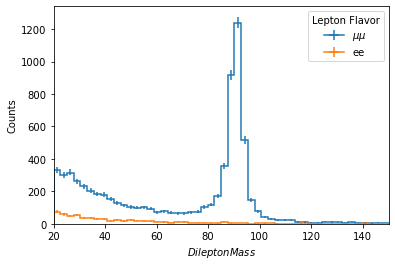

In [33]:
hist.plot1d(ll_hist)

We see the spike we expected in $\mu\mu$. Our ee data is too sparse to be meaningful. (That's because the present placeholder file is a muon dataset!)

### add transformation subsection

## **Processors**

Up until now, we have focused on the details of how Coffea can aid analysis. Once you have an analysis, you run into the separate problem of deploying that analysis, which will typically have a great number of events to be processed. Data in HEP is naturally conducive to distributed work, as events are independent and can be sent out to any number of workers. Many tools exist to handle this distribution, and Coffea has executors which permit the deployment of any analysis on these tools. 

The only catch is that we need to encapsulate our analysis in a processor. Below, we have placed the Z mass analysis into a processor. Let's first prove that it outputs the desired result and then examine its parts.

In [34]:
import coffea.processor as processor

class Processor(processor.ProcessorABC):
    def __init__(self):
        ll_bin = hist.Bin("dilep_mass", "$Dilepton Mass$", 50, 20, 150)
        ll_cat = hist.Cat("lepton", "Lepton Flavor")
        
        self._accumulator = hist.Hist("Counts", ll_cat, ll_bin)
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dimuons = events.Muon[(ak.num(events.Muon, axis=1) == 2) & (ak.sum(events.Muon.charge, axis=1) == 0)]
        dielectrons = events.Electron[(ak.num(events.Electron, axis=1) == 2) & (ak.sum(events.Electron.charge, axis=1) == 0)]
        mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass
        ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass
        
        output.fill(lepton='$\mu\mu$', dilep_mass=mumu_mass)
        output.fill(lepton='ee', dilep_mass=ee_mass)
        
        return output
        
    def postprocess(self, accumulator):
        pass

To actually execute our analysis, we need a few more blocks of code. The above processor, however, contains all of the actual analysis. At coffea-casa, we execute analyses on Dask:

In [35]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

from dask.distributed import Client
client = Client("tls://localhost:8786")

run = processor.Runner(executor=processor.DaskExecutor(client=client),
                      schema=NanoAODSchema,
                      chunksize=100000,
                      maxchunks=1)

output = run(fileset, "Events", Processor())

<AxesSubplot:xlabel='$Dilepton Mass$', ylabel='Counts'>

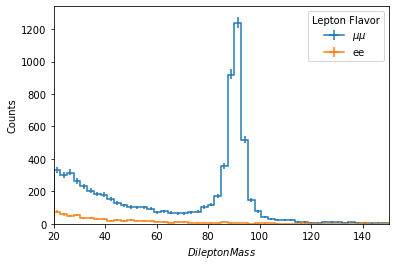

In [36]:
hist.plot1d(output)

So, what exactly is happening and how is it different from the behavior above? The trick is in our <code>accumulator</code>. When we deploy our processor onto an executor, our data is broken up in chunks of (approximately) equal size. Our actual analysis - contained in the <code>process()</code> method - is executed on each of these chunks independently, so each chunk can go to a different worker. When processing is done, we add the results of each chunk into an accumulator, which aggregates all the chunks' results together. For our purposes, our accumulator is just a histogram.

Where did we define this histogram? In <code>__init__</code>. Instead of defining our histogram last, we must define it first, so that each chunk can refer to it. If we want to do any post-processing or histogram transformations, we can do it in the <code>postprocess()</code> method.

Now, for a practical analysis, one will want to make many histograms rather than a single one. For this purpose, Coffea is equipped with various other accumulators. A commonly used one, for example, is the <code>dict_accumulator</code>, which functions as a dictionary (of hists) which is capable of accumulating data into each of its keys. Accumulators exist for most relevant output formats.

For pedagogical purposes, let's turn our attention next to the executor. The format of this code is relatively "standardized" to the executor you're using, but we can poke at it anyways. Recall:

```python
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

from dask.distributed import Client
client = Client("tls://localhost:8786")

run = processor.Runner(executor=processor.DaskExecutor(client=client),
                      schema=NanoAODSchema,
                      chunksize=100000,
                      maxchunks=1)

output = run(fileset, "Events", Processor())
```

The requirement of a Client is a quirk of Dask, where the Client acts as the scheduler for the workers. The <code>tls://localhost:8786</code> address in coffea-casa will point to the scheduler of the current user, so it runs on resources allocated specifically to you. The <code>run</code> block is what actually creates our executor; we use the Dask executor, we use our schema, and we only want the first 100000 events. Thus, we ask for 1 chunk of 100000 events. Then the <code>output</code> line runs our processor on the executor with our specified fileset, using the <code>Events</code> tree.

Of course, that means we aren't actually distributing any worker - we have one chunk. We could run the processor again on all of our data here; the reason we avoided this initially is because it would take too long to instantiate a large dataset. Dask helps us avert that problem. Note that running on all data is default behavior, so:

<AxesSubplot:xlabel='$Dilepton Mass$', ylabel='Counts'>

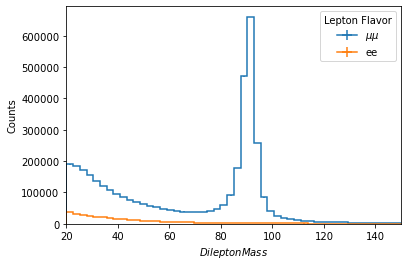

In [37]:
run = processor.Runner(executor=processor.DaskExecutor(client=client),
                      schema=NanoAODSchema)

output = run(fileset, "Events", Processor())

hist.plot1d(output)

This looks deceptively close to our previous plot. Take note that they are not, however, identical, as the counts numbers indicate. Indeed, this second graph has a lot more data.

## **Appendix**
### Lookup Tools
### ServiceX

## **Acknowledgements**